In [39]:
import json
import os
import time
import numpy as np
import pandas as pd
import faiss
import torch
import gradio as gr
import webbrowser
from scholarly import scholarly
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer
from adapters import AutoAdapterModel
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

# === Make sure pytorch & GPU support are loaded correctly ===
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())



2.6.0+cu124
CUDA available: True


In [ ]:
# === 1. Load SPECTER2 with proximity adapter ===
tokenizer = AutoTokenizer.from_pretrained("allenai/specter2_base")
model = AutoAdapterModel.from_pretrained("allenai/specter2_base")
model.load_adapter("allenai/specter2", source="hf", load_as="proximity", set_active=True)
model.eval()

# === 2. Get papers from Google Scholar ===
def get_org_papers(gs_profile_id, max_papers=20):
    author = scholarly.search_author_id(gs_profile_id)
    author_filled = scholarly.fill(author, sections=["publications"])
    paper_list = []
    for pub in author_filled["publications"][:max_papers]:
        try:
            pub_filled = scholarly.fill(pub)
            paper_list.append({
                "title": pub_filled.get("bib", {}).get("title", ""),
                "abstract": pub_filled.get("bib", {}).get("abstract", ""),
                "year": pub_filled.get("bib", {}).get("pub_year", ""),
                "venue": pub_filled.get("bib", {}).get("venue", ""),
                "authors": pub_filled.get("bib", {}).get("author", ""),
            })
            time.sleep(1)
        except Exception as e:
            print(f"❌ Error loading pub: {e}")
            continue
    return paper_list

# === 3. Embed papers with SPECTER2 ===
def embed_papers(papers):
    texts = [p["title"] + tokenizer.sep_token + p.get("abstract", "") for p in papers]
    inputs = tokenizer(texts, padding=True, truncation=True,
                       return_tensors="pt", return_token_type_ids=False, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

# === 4. Build FAISS index ===
def build_index(embeddings):
    if embeddings.size == 0:
        raise ValueError("❌ No embeddings provided.")

    if np.any(np.isnan(embeddings)) or np.any(np.isinf(embeddings)):
        raise ValueError("❌ Embeddings contain NaNs or Infs. Check model outputs.")
    
    embeddings = np.ascontiguousarray(embeddings.astype("float32"))
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    faiss.normalize_L2(embeddings)
    index.add(embeddings)
    return index

# === 5. Save and Load Index ===
def save_index_and_data(embeddings, index, papers, dir_path="index_data"):
    os.makedirs(dir_path, exist_ok=True)
    faiss.write_index(index, os.path.join(dir_path, "index.faiss"))
    np.save(os.path.join(dir_path, "embeddings.npy"), embeddings)
    with open(os.path.join(dir_path, "metadata.json"), "w") as f:
        json.dump(papers, f)

def load_index_and_data(dir_path="index_data"):
    index = faiss.read_index(os.path.join(dir_path, "index.faiss"))
    embeddings = np.load(os.path.join(dir_path, "embeddings.npy"))
    with open(os.path.join(dir_path, "metadata.json"), "r") as f:
        papers = json.load(f)
    return papers, embeddings, index

# === 6. Compute pairwise similarity table ===
def compute_pairwise_similarity_table(papers, embeddings, threshold=.9):
    sims = cosine_similarity(embeddings)
    results = []
    for i in range(len(papers)):
        for j in range(i + 1, len(papers)):
            results.append({
                "paper_A_title": papers[i]["title"],
                "paper_B_title": papers[j]["title"],
                "paper_A_authors": papers[i].get("authors", ""),
                "paper_B_authors": papers[j].get("authors", ""),
                "similarity": round(sims[i, j], 4)
            })
    results = sorted(results, key=lambda x: x["similarity"], reverse=True)
    df = pd.DataFrame([r for r in results if r["similarity"] >= threshold])
    df.to_csv("pairwise_similarity.csv", index=False)
    return df

# === 7. Visualizations ===
def build_similarity_graph(pairwise_df, threshold=0.9):
    G = nx.Graph()
    for _, row in pairwise_df.iterrows():
        if row["similarity"] >= threshold:
            G.add_edge(row["paper_A_title"], row["paper_B_title"], weight=row["similarity"])
    return G

def draw_similarity_graph(G, figsize=(12, 8)):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=figsize)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", edge_color="gray")
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
    plt.title("Semantic Similarity Graph")
    plt.show()

def build_interactive_graph(pairwise_df, threshold=0.85, output_file="similarity_graph.html", highlight_nodes=None):
    net = Network(height="750px", width="100%", notebook=False)
    added_nodes = set()
    highlight_nodes = highlight_nodes or []

    color_map = {
        0: "orange",
        1: "green",
        2: "red"
    }

    for _, row in pairwise_df.iterrows():
        if row["similarity"] >= threshold:
            a, b = row["paper_A_title"], row["paper_B_title"]

            for node, author in [(a, row["paper_A_authors"]), (b, row["paper_B_authors"])]:
                if node not in added_nodes:
                    color = color_map[highlight_nodes.index(node)] if node in highlight_nodes else "blue"
                    net.add_node(
                        node,
                        title=author,
                        label=node,
                        color=color
                    )
                    added_nodes.add(node)

            net.add_edge(a, b, value=row["similarity"])

    net.show_buttons(filter_=["physics"])
    net.write_html(output_file)
    print(f"✅ Interactive graph saved to: {output_file}")
    webbrowser.open(output_file)

def interactive_graph_with_gradio(pairwise_df, threshold=0.88):
    paper_titles = sorted(set(pairwise_df["paper_A_title"]).union(set(pairwise_df["paper_B_title"])))

    def generate_graph(selected_titles):
        if not selected_titles:
            return "⚠️ Please select at least one paper."
        if len(selected_titles) > 3:
            return "⚠️ Please select up to 3 papers only."
        build_interactive_graph(pairwise_df, threshold=threshold, highlight_nodes=selected_titles)
        return f"✅ Graph with highlighted papers: {', '.join(selected_titles)}"

    gr.Interface(
        fn=generate_graph,
        inputs=gr.Dropdown(
            choices=paper_titles,
            multiselect=True,
            label="Select up to 3 papers to highlight",
            allow_custom_value=False,
            max_choices=3  # Enforced in logic as well
        ),
        outputs=gr.Textbox(label="Status"),
        title="🔍 Explore Paper Similarity Graph",
        description="Search and select up to 3 papers to highlight in the semantic similarity network."
    ).launch()


# === 8. Gradio UI ===
def launch_gradio(papers, index, embeddings):
    def recommend(title, abstract, top_k):
        text = title + tokenizer.sep_token + abstract
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True,
                           return_token_type_ids=False, max_length=512)
        with torch.no_grad():
            output = model(**inputs)
        query_embedding = output.last_hidden_state[:, 0, :].cpu().numpy()
        faiss.normalize_L2(query_embedding)
        scores, indices = index.search(query_embedding, top_k)
        results = []
        for score, idx in zip(scores[0], indices[0]):
            paper = papers[idx]
            results.append(f"🔹 **{paper['title']}** ({paper['venue']}, {paper['year']})\nScore: {score:.3f}")
        return "\n\n".join(results)

    gr.Interface(
        fn=recommend,
        inputs=[
            gr.Textbox(label="Title"),
            gr.Textbox(label="Abstract"),
            gr.Slider(minimum=1, maximum=10, step=1, label="Top K Results", value=5)
        ],
        outputs=gr.Markdown(),
        title="📚 Citation Recommender",
        description="Find semantically similar papers from your Google Scholar corpus."
    ).launch()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Loaded cached index and papers.


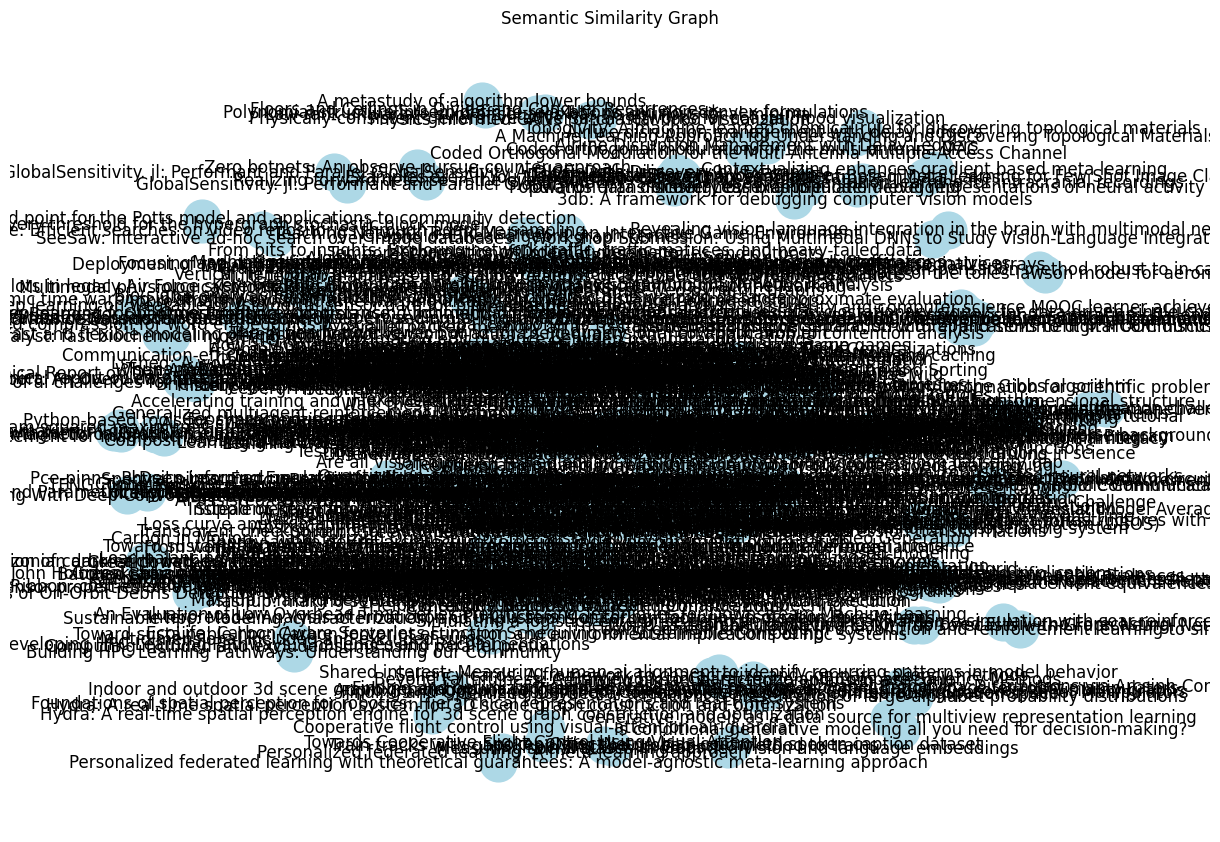

✅ Interactive graph saved to: similarity_graph.html
Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.


In [60]:
# === 9. Run it all ===
google_scholar_id = "Zid_jw4AAAAJ"
try:
    papers, embeddings, index = load_index_and_data()
    print("✅ Loaded cached index and papers.")
except:
    print("🚀 Building index from scratch...")
    papers = get_org_papers(google_scholar_id, max_papers=-1)
    embeddings = embed_papers(papers)
    index = build_index(embeddings)
    save_index_and_data(embeddings, index, papers)

pairwise_df = compute_pairwise_similarity_table(papers, embeddings, threshold=.92)
G = build_similarity_graph(pairwise_df, threshold=0.92)
draw_similarity_graph(G)
build_interactive_graph(pairwise_df, threshold=0.92)
interactive_graph_with_gradio(pairwise_df, threshold=0.92)

launch_gradio(papers, index, embeddings)

In [61]:
# High-relevance query
query_high = {
    "title": "Safe Reinforcement Learning for Neural Control Systems",
    "abstract": (
        "We propose a novel architecture for training neural policies that satisfy safety constraints "
        "throughout the learning process. Inspired by biological control systems, our framework enables "
        "interpretable and robust decision-making in high-speed locomotion tasks."
    )
}

# Low-relevance query
query_low = {
    "title": "A Historical Analysis of Classical Music in the Baroque Period",
    "abstract": (
        "This paper presents a comparative study of musical compositions during the Baroque era, analyzing "
        "the influence of political and religious institutions on stylistic developments across regions. "
        "We explore thematic evolution, instrumentation, and harmonic structure in the works of Bach and Vivaldi."
    )
}

def embed_query(query_dict):
    text = query_dict["title"] + tokenizer.sep_token + query_dict["abstract"]
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, return_token_type_ids=False)
    with torch.no_grad():
        output = model(**inputs)
    emb = output.last_hidden_state[:, 0, :].cpu().numpy()
    emb = np.ascontiguousarray(emb.astype("float32"))
    faiss.normalize_L2(emb)
    return emb

In [62]:
def search_and_print(query_embedding, label, papers, index, top_k=5):
    scores, indices = index.search(query_embedding, top_k)
    print(f"\n🔍 Top {top_k} results for: **{label}**")
    for score, idx in zip(scores[0], indices[0]):
        p = papers[idx]
        print(f"🔹 {p['title']} ({p['venue']}, {p['year']})\nScore: {score:.3f}\n")

emb_high = embed_query(query_high)
emb_low = embed_query(query_low)

search_and_print(emb_high, "Safe Reinforcement Learning", papers, index)
search_and_print(emb_low, "Baroque Music History", papers, index)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



🔍 Top 5 results for: **Safe Reinforcement Learning**
🔹 Rapid locomotion via reinforcement learning (, 2024)
Score: 0.945

🔹 Barriernet: Differentiable control barrier functions for learning of safe robot control (, 2023)
Score: 0.944

🔹 Barriernet: A safety-guaranteed layer for neural networks (, 2021)
Score: 0.944

🔹 Growing Q-networks: Solving continuous control tasks with adaptive control resolution (, 2024)
Score: 0.943

🔹 ABNet: Attention BarrierNet for Safe and Scalable Robot Learning (, 2024)
Score: 0.943


🔍 Top 5 results for: **Baroque Music History**
🔹 The Pseudo Projection Operator: Applications of Deep Learning to Projection Based Filtering in Non-Trivial Frequency Regimes (, 2021)
Score: 0.852

🔹 10th International Conference on Fun with Algorithms (FUN 2021) (, 2020)
Score: 0.847

🔹 Bio-signal analysis for personalized pilot training (, 2022)
Score: 0.832

🔹 Binary dynamic time warping in linear time (, 2021)
Score: 0.824

🔹 Who Provides the Largest Megaphone? The Role o

In [69]:
import umap
import hdbscan
import pandas as pd
import numpy as np
import plotly.express as px
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Combine embeddings
all_embeddings = np.vstack([embeddings, emb_high, emb_low])
labels = [p["title"] for p in papers] + ["[Query: RL Safety]", "[Query: Baroque Music]"]
types = ["Paper"] * len(papers) + ["Query: RL Safety", "Query: Baroque Music"]

# === 1. UMAP dimensionality reduction ===
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric="cosine", random_state=42)
proj = reducer.fit_transform(all_embeddings)

# === 2. HDBSCAN clustering (only for papers) ===
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric="euclidean")
cluster_labels = clusterer.fit_predict(embeddings)
umap_df = pd.DataFrame(proj, columns=["x", "y"])
umap_df["label"] = labels
umap_df["type"] = types
umap_df["cluster"] = list(cluster_labels) + ["Query", "Query"]

# === 3. c-TF-IDF keyword extraction ===
abstracts = [p["abstract"] or "" for p in papers]
df_tfidf = pd.DataFrame({"doc": abstracts, "cluster": cluster_labels})
df_tfidf = df_tfidf[df_tfidf["cluster"] != -1]  # skip outliers

# Group text by cluster
docs_per_cluster = df_tfidf.groupby("cluster")["doc"].apply(lambda x: " ".join(x)).tolist()
vectorizer = CountVectorizer(stop_words="english", max_features=3000)
X = vectorizer.fit_transform(docs_per_cluster)
tfidf = TfidfTransformer().fit_transform(X)
terms = np.array(vectorizer.get_feature_names_out())
top_words_per_cluster = [
    ", ".join(terms[row.toarray().argsort()[0][-5:][::-1]]) for row in tfidf
]
cluster_id_to_words = dict(zip(df_tfidf["cluster"].unique(), top_words_per_cluster))

# === 3b. Get clean top 2-word author names per cluster ===
import re
from collections import Counter

def extract_two_word_ngrams(text):
    # Remove punctuation and normalize
    text = re.sub(r"[^\w\s]", "", text)
    words = text.lower().split()
    ngrams = [" ".join(words[i:i+2]) for i in range(len(words)-1)]
    return [ng for ng in ngrams if "and" not in ng.split()]

# === 3b. Compute top 2-word author n-grams per cluster ===
cluster_author_map = {}
for cluster_id in np.unique(cluster_labels):
    if cluster_id == -1:
        continue
    ngram_counter = Counter()
    for i, c in enumerate(cluster_labels):
        if c == cluster_id:
            author_text = papers[i].get("authors", "")
            ngrams = extract_two_word_ngrams(author_text)
            ngram_counter.update(ngrams)
    top_ngrams = [ngram for ngram, _ in ngram_counter.most_common(3)]
    cluster_author_map[cluster_id] = ", ".join(top_ngrams)



# === 4. Simplified label column ===
def simple_cluster_label(row):
    if row["type"].startswith("Query"):
        return row["type"]
    elif row["cluster"] == -1:
        return "Noise"
    else:
        return f"Cluster {row['cluster']}"

# === 5. Add hover details ===
def tooltip_details(row):
    if row["type"].startswith("Query"):
        return row["type"]
    elif row["cluster"] == -1:
        return "Noise point"
    else:
        words = cluster_id_to_words.get(row["cluster"], "")
        authors = cluster_author_map.get(row["cluster"], "")
        return f"Top terms: {words}<br>Top authors: {authors}"

umap_df["cluster_label"] = umap_df.apply(simple_cluster_label, axis=1)
umap_df["hover"] = umap_df.apply(tooltip_details, axis=1)

# === 6. Plot ===
fig = px.scatter(
    umap_df,
    x="x",
    y="y",
    color="cluster_label",
    hover_name="label",
    hover_data={"hover": True, "x": False, "y": False, "cluster_label": False},
    title="📚 UMAP with HDBSCAN Clusters (Hover for TF-IDF + Top Authors)",
    width=1000,
    height=650,
    color_discrete_map={
        "Query: RL Safety": "green",
        "Query: Baroque Music": "red",
        "Noise": "gray"
    }
)

fig.update_traces(marker=dict(size=10, line=dict(width=1, color="DarkSlateGrey")))
fig.update_layout(legend_title_text="Group Type")
fig.show()


/home/eric/.conda/envs/aia-papers/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/eric/.conda/envs/aia-papers/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/eric/.conda/envs/aia-papers/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/eric/.conda/envs/aia-papers/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

